# Approximate (Deep) Q-Learning
## Using TF-2
## Using Experience replay
## Parallelized Sessions and Update
### Tested on CartPole-v0

##### This is another oop approach

In [4]:
import gym
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## TF Stuff to do beforehand

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L

In [6]:
#Checking GPU Use
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


## Create our DNN model to be used for approximating Q values

#### Currently this is just a simple model
`Input(state_dims) -> Dense(400, relu) -> Dense(400, relu) -> Dense(n_actions, linear)`

##### Subclassing allows for more complex networks, so yeah this is good

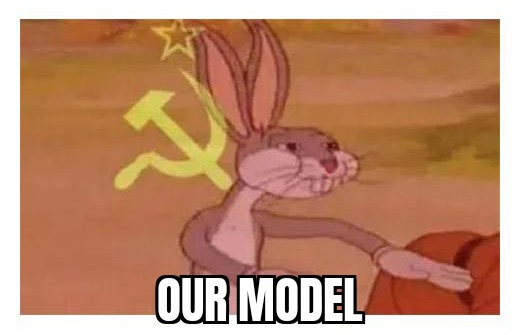

If you know you know

In [7]:
#We need to first create our custom model class
#This can be utilized for more complex networks

class OurDNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(OurDNN, self).__init__()
        #Input layer
        self.inp = L.InputLayer(input_dim)
        #Hidden layers here - ReLu
        self.hd1 = L.Dense(400, kernel_initializer='uniform', activation='relu')
        self.hd2 = L.Dense(400, kernel_initializer='uniform', activation='relu')
        #Output layer here - linear
        self.out = L.Dense(output_dim, kernel_initializer='uniform', activation='linear')
    
    @tf.function
    def call(self, input_data):
        #Essentially feedforward your network
        inp_fwd = self.inp(input_data)
        hd1_fwd = self.hd1(inp_fwd)
        hd2_fwd = self.hd2(hd1_fwd)
        out_fwd = self.out(hd2_fwd)
        #Get the output
        return out_fwd        

## Create our AQL Agent

### The loss function for our agent is defined as - 
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

Since $Q_{-}(s',a')$ is kept constant for our semi-grad Q-Learning, we will use `tf.stop_gradient` for this

### The update equation is defined as
$$ \textbf{w} \leftarrow \textbf{w} + \alpha*\nabla_{\textbf w}L(\textbf w)$$

In [8]:
class OurAgent:
    def __init__(self, envs, optimizer, epsilon=0.5, gamma=0.99, buffer_size=0, load=False):
        
        #Set up constants
        self.state_dim = envs[0].observation_space.shape
        self.n_actions = envs[0].action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.envs = envs
        self.optimizer = optimizer
        self.buffer = None
        self.num_envs = len(envs)
        
        #Create the model
        if load:
            self.model = keras.models.load_model("./models/tf2_cart_model/")
            self.model.summary()
        else:
            self.model = OurDNN(self.state_dim, self.n_actions)
            self.model.compile(self.optimizer)
            
        #If buffer size is not 0
        if buffer_size:
            self.buffer = ReplayBuffer(buffer_size)
            print("LOG: Using Experience Replay")
            
    def get_actions(self, states):
        '''
        Uses E-greedy policy to get the agent actions
        '''
        #Approximate the q_values
        q_values = self.model.predict(states)
        
        #Explore or exploit
        ore_or_oit = np.random.choice([0,1], p =[self.epsilon, 1-self.epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_actions = np.random.choice(self.n_actions, self.num_envs) #Over uniform dist
        #If wanna exploit
        else:
            chosen_actions = np.argmax(q_values, axis=1)
            
        return chosen_actions
    
    def get_loss(self, state, action, next_state, reward, is_done):
        '''
        Get the loss function as defined above
        '''
        #Get 𝑄𝜃(s,a)
        pred_q = self.model(np.atleast_2d(state.astype('float32')))
        pred_q_for_a = tf.reduce_sum(pred_q * tf.one_hot(action, self.n_actions), axis=1)
        
        #Get Q_(s',a')
        pred_next_q = self.model(np.atleast_2d(next_state.astype('float32')))
        #Get V_(s',a') using Q
        next_v = tf.math.reduce_max(pred_next_q, axis=1)
        #Get target Q-value, Q_(s',a')
        target_q_for_a = reward + self.gamma*next_v
        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_q_for_a = tf.where(is_done, reward, target_q_for_a)
        
        #Calculate loss
        loss = (pred_q_for_a - tf.stop_gradient(target_q_for_a)) ** 2
        loss = tf.reduce_mean(loss)
        return loss
        
    def train_step(self, network, state, action, next_state, reward, is_done):
        '''
        Trains the given network wrt the custom loss function
        '''
        #Variables to train - here weight
        variables = network.trainable_variables
        
        #Perform semi-grad Q Learning with Adam optimizer
        with tf.GradientTape() as tape:
            loss = self.get_loss(state, action, next_state, reward, is_done)
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
    
    def env_step(self, env_index, action, envs_running):
        '''
        Perform step action for particular environment
        '''
        #Convenience function for joblib
        #Performs env run only if it's running
        if env_index in envs_running:
            return self.envs[env_index].step(action)
        else:
            return np.array([np.array([0,0,0,0]), 0.0, True, {}])
    
    def generate_session(self, t_max=1000, train=False, batch_size=32):
        '''
        Run environment and train
        '''
        total_reward = np.zeros(self.num_envs)
        self.num_envs = len(self.envs)
        #Run num_envs number of environments in parallel
        s = np.array(Parallel(n_jobs=self.num_envs, prefer="threads")
                     (delayed(self.envs[i].reset)() for i in range(self.num_envs)))
        
        #Create a list of running environment indexes
        envs_started = np.array(range(self.num_envs))
        envs_running = envs_started
        
        num_done = 0
        
        for t in range(t_max):
            #Get the length of current environments
            self.num_run = len(envs_running)
            
            a = self.get_actions(s)

            out = np.array(Parallel(n_jobs=self.num_envs, prefer="threads")
                           (delayed(self.env_step)(i,a[i],envs_running) for i in range(self.num_envs)))

            next_s, r, done, _ = np.rollaxis(out,1)
            next_s = np.stack(next_s)
            if train:
                #Train over all the collected samples
                #Train over the environments that are still running
                for i in envs_running:
                    self.train_step(self.model, s[i], a[i], next_s[i], r[i], done[i])
                    if self.buffer is not None:
                        #Store data
                        data = (s[i],a[i],r[i],next_s[i],done[i])
                        self.buffer.add(*data)
                
                #if experience replay is turned on
                if self.buffer is not None:
                    #Sample data
                    s_,a_,r_,next_s_,done_ = self.buffer.sample(batch_size)
                    for i in range(batch_size):
                        self.train_step(self.model, 
                                        s_[i], a_[i], 
                                        next_s_[i], 
                                        r_[i], 
                                        done_[i])
            
            #Only update rewards for those that are running
            total_reward[done==False] = total_reward[done==False]+r[done==False]
            s = next_s
#             print(total_reward)
            #Set the running environments from the ones that started
            envs_running = envs_started[done == False]
#             clear_output(True)
#             if np.sum(done) != num_done:
#                 num_done = np.sum(done)
#                 print(num_done, "out of 8")
            
            #If all environments are over
            if done.all():
                break
                
        return total_reward
    
    def save(self):
        self.model.save("./models/tf2_cart_model", save_format="tf")

## Create Experience Replay Buffer using deque

In [9]:
from collections import deque
#Deque has a better time complexity

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        """
        self._storage = deque()
        self._maxsize = size

    def __len__(self):
        return len(self._storage)
    
    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Add new elements into the FIFO buffer
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        #FIFO Check!
        if len(self._storage) >= self._maxsize:
            #If not good, pop first element
            self._storage.popleft()

        #Now append the data
        self._storage.append(data)
    
    def sample(self, batch_size):
        """
        Sample a batch of experiences.
        """
        #Sample random indexes from the buffer
        idxes = np.random.randint(len(self._storage), size=batch_size)

        #First convert the data to numpy array
        np_storage = np.array(self._storage)
        
        #Now use these indexes to get the samples
        samples = np_storage[idxes]
        #Return corresponding values
        return(
#             np.stack(samples[:,0]),
            samples[:,0],
            samples[:,1],
            samples[:,2],
#             np.stack(samples[:,3]),
            samples[:,3],
            samples[:,4]
        )

## Time to run stuff

In [10]:
#We will use Adam optimizer here
optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
#Create 8 environments for 8 cores
envs = [gym.make("CartPole-v0").env for i in range(8)]

In [12]:
#Agent using cartpole environments and Adam optimizer
agent = OurAgent(envs, optimizer, buffer_size=1024, load=True)

Model: "our_dnn_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             multiple                  2000      
_________________________________________________________________
dense_13 (Dense)             multiple                  160400    
_________________________________________________________________
dense_14 (Dense)             multiple                  802       
Total params: 163,202
Trainable params: 163,202
Non-trainable params: 0
_________________________________________________________________
LOG: Using Experience Replay


Stopped
epoch #32	mean reward = 77.125	epsilon = 0.362


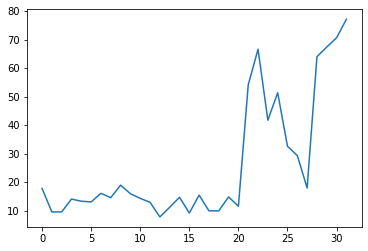

In [35]:
from IPython.display import clear_output

mean_rewards = []

max_reward = 0

try:
    for i in range(10000):
        session_rewards = agent.generate_session(train=True)
        mean_rewards.append(np.mean(session_rewards))
        #Make sure epsilon doesn't go below 0.1
        if agent.epsilon > 0.1:
            agent.epsilon *= 0.99
        clear_output(True)
        print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
        plt.plot(mean_rewards)
        plt.show()
        #Save weights for a new best state
        if mean_rewards[i] > max_reward:
            max_reward = mean_rewards[i]
            agent.save()
        if np.mean(session_rewards) > 300:
            print("You Win! Stop using Keyboard Interrupt")
    #         break
    
except KeyboardInterrupt:
    clear_output(True)
    print("Stopped")
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
    plt.plot(mean_rewards)
    plt.show()

In [13]:
agent.save()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/tf2_cart_model/assets


In [ ]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    agent.envs = [env_monitor]
    
    sessions = agent.generate_session(train=False)
    print(sessions)

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [ ]:
def func(pert):
    print("Kick")
    return "Fuck"

In [ ]:
Parallel(n_jobs=2)(delayed(func)(1) for i in range(10))

In [ ]:
len(envs)

In [ ]:
q_vals = agent.model.predict(s)

In [ ]:
q_vals

In [ ]:
np.argmax(q_vals, axis=1)

In [ ]:
agent.envs